# verification of the C3S MME probabilistic SST forecasts around NZ 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%xmode minimal
import warnings

warnings.filterwarnings("ignore")

Exception reporting mode: Minimal


In [3]:
%matplotlib inline

In [4]:
import cmocean
import palettable
from matplotlib import pyplot as plt

In [5]:
fig_kwargs = {'dpi':200, 'bbox_inches':'tight', 'facecolor':'w'}

In [6]:
from IPython.display import clear_output

In [7]:
import pathlib
import sys

In [8]:
import seaborn as sns

In [9]:
from seasonal_forecasting import C3S, domains, geo, plot, utils, verification

In [10]:
from calendar import month_abbr
from datetime import datetime, timedelta

In [11]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import regionmask
import xarray as xr

### climpred HindcastEnsemble Class + logging

In [12]:
import logging

from climpred import HindcastEnsemble

### progress bar for dask compute 

In [13]:
from dask.diagnostics import ProgressBar

### path definitions 

In [14]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

In [15]:
fig_path = pathlib.Path("../figures/verification/SST")

In [16]:
fig_path.mkdir(parents=True, exist_ok=True)

In [17]:
fig_path

PosixPath('../figures/verification/SST')

### parameters for papermill

In [18]:
domain_name = "NZ"
use_verif = "oisst"
GCMs = [
    "ECMWF",
    "UKMO",
    "METEO_FRANCE",
    "DWD",
    "CMCC",
    "NCEP",
    "JMA",
    "ECCC_CanCM4i",
    "ECCC_GEM5_NEMO",
]
varname = "sst"
period = "monthly"  # 'seasonal' or 'monthly'
year_start = 1993
year_end = 2016
obs_to_1deg = False
climpred_verbose = False
q = 0.9

### logging, to see what `climpred` is doing under the hood, if `climpred_verbose` is set to True, then all inits and corresponding verif times are printed

### Note: setting it to True causes issues with Matplotlib, which outputs endless debug messages related to the font manager, so setting it to `False` is safer

In [19]:
logger = logging.getLogger()

if climpred_verbose:

    logger.setLevel(logging.DEBUG)

else:

    logger.setLevel(logging.INFO)

### dictionnary of domains 

In [20]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [21]:
domain = domains.domains[domain_name]

### creates a map delineating the validation domain 

In [22]:
area = geo.gpd_from_domain(*domain)

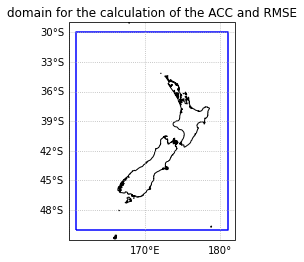

In [23]:
f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})
area.geometry.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color="b")
ax.coastlines(resolution="10m")
ax.set_title("domain for the calculation of the ACC and RMSE")
gl = ax.gridlines(
    draw_labels=True,
    linestyle=":",
    xlocs=np.arange(-180, 180, 10),
    crs=ccrs.PlateCarree(),
)
gl.top_labels = False
gl.right_labels = False

### reads in the verification dataset 

In [24]:
if use_verif == "ersst":
    dset_obs, dset_obs_anoms = verification.get_ERSST(
        access="opendap", start=year_start, end=year_end, detrend=True
    )
elif use_verif == "oisst":
    dset_obs, dset_obs_anoms = verification.get_OISST(
        start=year_start, end=year_end, detrend=True
    )

### regrid to 1deg X 1deg (if `obs_to_1deg` is set to True)

In [25]:
if obs_to_1deg:

    dset_obs = utils.interp_to_1x(dset_obs)

    dset_obs_anoms = utils.interp_to_1x(dset_obs_anoms)

### now selects domain 

In [26]:
dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

In [27]:
dset_obs_anoms = dset_obs_anoms.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

In [28]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (time, lat, lon) float32 10.46 10.46 10.43 ... 21.96 21.89 21.8

### creates a mask from the observational dataset 

In [29]:
mask_obs = dset_obs.mean(dim="time")

In [30]:
mask_obs = mask_obs.where(np.isnan(mask_obs), 1)

In [31]:
mask_obs = mask_obs.rename({varname: "mask"})["mask"]

### plots the mask 

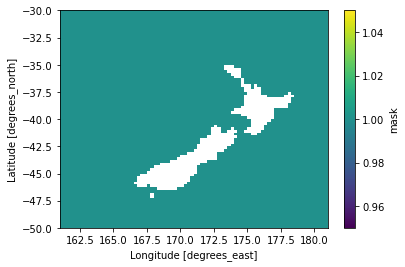

In [32]:
mask_obs.plot()

### calculates seasonal averages if 'seasonal' 

In [33]:
if period == "seasonal":

    dset_obs = dset_obs.rolling({"time": 3}, min_periods=3).mean("time")

    dset_obs = dset_obs.isel(time=slice(2, None))

    dset_obs_anoms = dset_obs_anoms.rolling({"time": 3}, min_periods=3).mean("time")

    dset_obs_anoms = dset_obs_anoms.isel(time=slice(2, None))

### calculates the quantile climatologies for the observations 

In [34]:
obs_edges = (
    dset_obs.groupby("time.month")
    .quantile(q=q, dim="time")
    .rename({"quantile": "category_edge"})
)

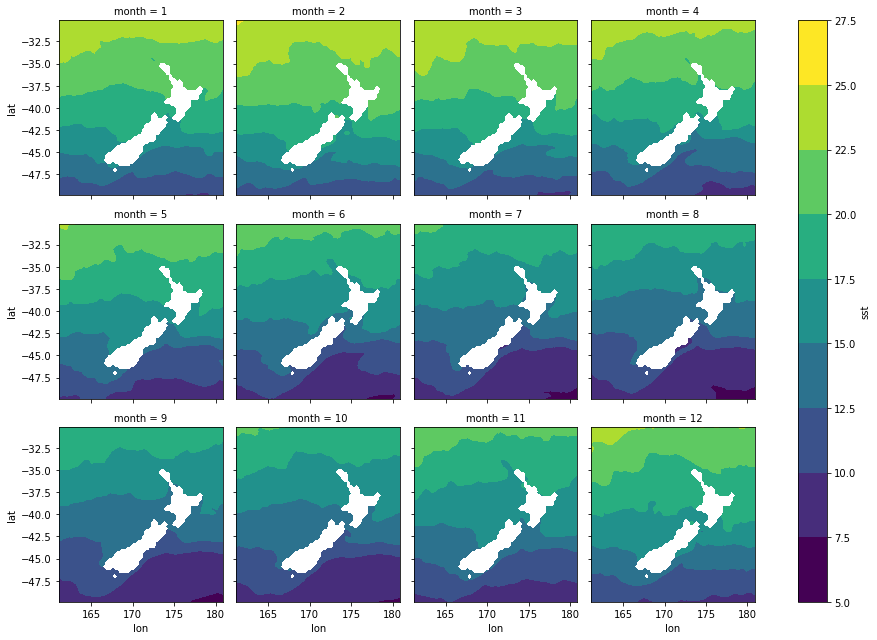

In [35]:
obs_edges[varname].plot.contourf(col='month', col_wrap=4, levels=10)

In [36]:
obs_edges

<xarray.Dataset>
Dimensions:        (lat: 80, lon: 80, month: 12)
Coordinates:
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
    category_edge  float64 0.9
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst            (month, lat, lon) float64 10.8 10.81 10.82 ... 22.47 22.4

In [37]:
obs_binary = []

for m in np.arange(12) + 1:

    obsm = dset_obs.sel(time=(dset_obs.time.dt.month == m))

    qm = obs_edges.sel(month=m)

    b = obsm >= qm

    obs_binary.append(b * mask_obs)

In [38]:
obs_binary = xr.concat(obs_binary, dim="time")

In [39]:
obs_binary = obs_binary.squeeze()

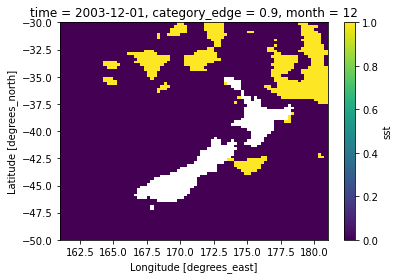

In [40]:
(obs_binary.sel(time="2003-12").squeeze() * mask_obs)["sst"].plot()

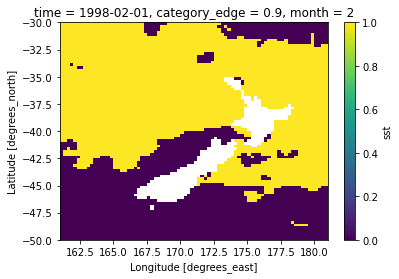

In [41]:
obs_binary.sel(time="1998-02").squeeze()["sst"].plot()

### check the anomalies

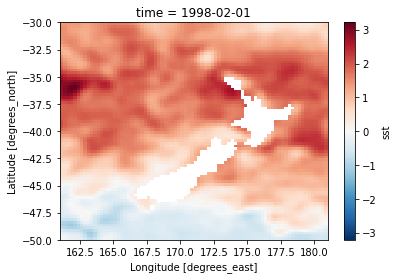

In [42]:
dset_obs_anoms.sel(time="1998-02").squeeze()["sst"].plot()

### Now reads in the GCM hindcasts (reforecasts / hindcasts)

In [43]:
dpath = "/media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/"

In [44]:
GCMs

['ECMWF',
 'UKMO',
 'METEO_FRANCE',
 'DWD',
 'CMCC',
 'NCEP',
 'JMA',
 'ECCC_CanCM4i',
 'ECCC_GEM5_NEMO']

In [45]:
dgcms = []

for GCM in GCMs:
    
    print(f"\nNow reading and processing {GCM} ... ")

    gcm = C3S.get_one_GCM(
        dpath=dpath,
        GCM=GCM,
        varname=varname,
        anomalies=False,
        ensemble_mean=False,
        domain=domain,
    )

    if GCM == "NCEP":

        print("Interpolating NCEP, calling `interp_NCEP`")

        gcm = utils.interp_NCEP(gcm, sst_hindcast_records="./SST_hindcast_summary.csv")

    else:

        gcm[varname] = utils.interpolate_NaN_da(gcm[varname].load())

    if period == "seasonal":

        gcm = gcm.rolling({"step": 3}, min_periods=3).mean("step")

        gcm = gcm.sel(step=slice(3, None))

    gcm = gcm.transpose("time", "member", "step", "lat", "lon")

    if not (obs_to_1deg):

        gcm = gcm.interp_like(dset_obs[["lon", "lat"]])

    gcm = gcm.chunk(
        {"member": -1, "time": -1, "step": -1, "lon": "auto", "lat": "auto"}
    )

    gcm = gcm * mask_obs

    gcm = gcm.compute()

    # calculate the empirical 90th percentile, for each initial month, across the time + members dimensions

    forecast_edges = (
        gcm.groupby("time.month")
        .quantile(q=q, dim=["time", "member"])
        .rename({"quantile": "category_edge"})
    )

    forecast_edges = forecast_edges.squeeze()

    # now derive binary forecasts, for each member of the GCM ensemble

    forecasts_binary = []

    for m in np.arange(12) + 1:

        forecastsm = gcm.sel(time=(gcm.time.dt.month == m))

        qm = forecast_edges.sel(month=m)

        b = forecastsm >= qm

        forecasts_binary.append(b * mask_obs)

    forecasts_binary = xr.concat(forecasts_binary, dim="time")

    forecasts_binary = forecasts_binary.sortby("time")

    # add that to the list

    dgcms.append(forecasts_binary)


Now reading and processing ECMWF ... 
getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_1993_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_2016_12_ECMWF.netcdf

Now reading and processing UKMO ... 
getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST
reading 287 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST/ensemble_seas_forecasts_sst_from_1993_02_UKMO.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST/ensemble_seas_forecasts_sst_from_2016_12_UKMO.netcdf

Now reading and processing METEO_FRANCE ... 
getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/METEO_FRANCE/SST
reading 288 files

first: /media/nicola

### concatenate accross the member dimension (all available members from all GCMs)

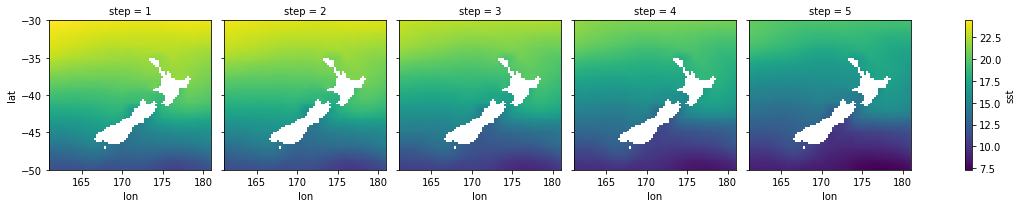

In [46]:
forecast_edges.sel(month=1)[varname].plot(col='step')

In [47]:
dgcms = xr.concat(dgcms, dim="member")

In [48]:
dgcms

<xarray.Dataset>
Dimensions:        (time: 288, step: 5, lon: 80, lat: 80, member: 206)
Coordinates:
  * time           (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step           (step) int64 1 2 3 4 5
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * member         (member) int32 0 1 2 3 4 5 6 7 8 9 10 ... 0 1 2 3 4 5 6 7 8 9
    category_edge  float64 0.9
    month          (member, time) float64 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
Data variables:
    sst            (time, member, step, lat, lon) float32 0.0 0.0 ... 0.0 0.0

In [49]:
dgcms['member'] = (('member'), np.arange(len(dgcms['member'])))

In [50]:
dgcms.member.data

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

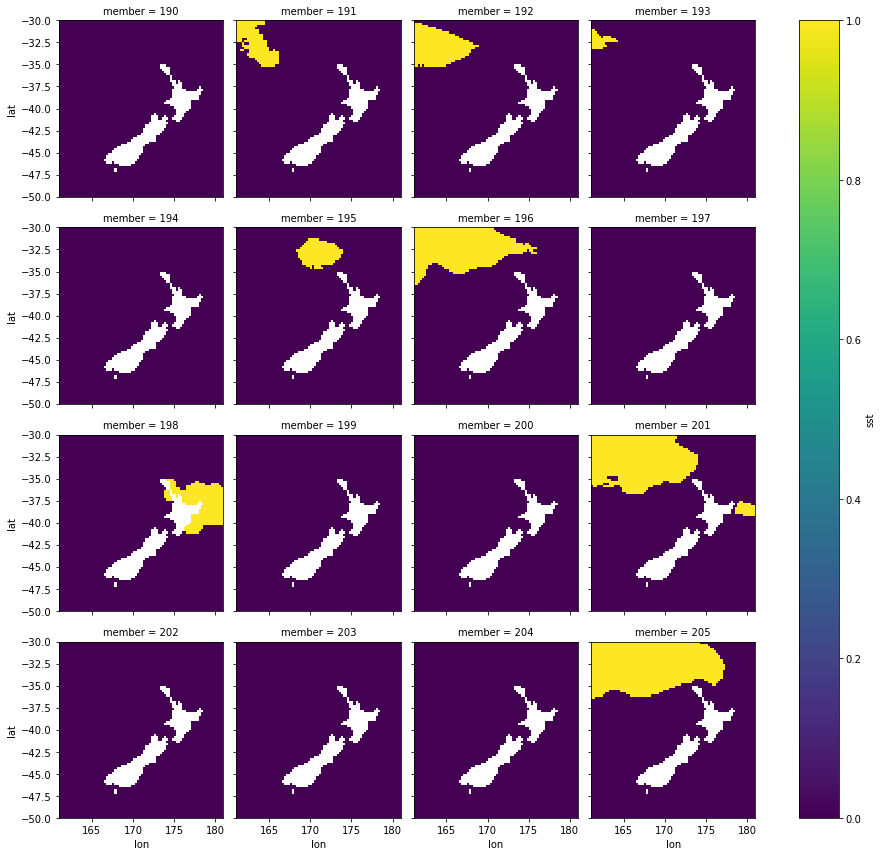

In [51]:
dgcms.sel(member=slice(190, 205), time='1998-01', step=1).squeeze()[varname].plot(col='member', col_wrap=4)

### calculate the forecast probabilities as the average of the binary forecasts across the member dimension 

In [52]:
dgcms_probs = dgcms.mean("member")

Text(0.5, 1.0, 'MHW probability, forecast 2016-08\ninitialization 2016-07')

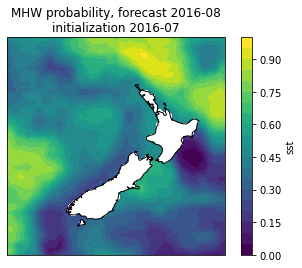

In [53]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
dgcms_probs.sel(time="2016-07", step=1).squeeze()["sst"].plot.contourf(transform=ccrs.PlateCarree(), levels=20)
ax.coastlines()
ax.set_title('MHW probability, forecast 2016-08\ninitialization 2016-07')

### quick plot 

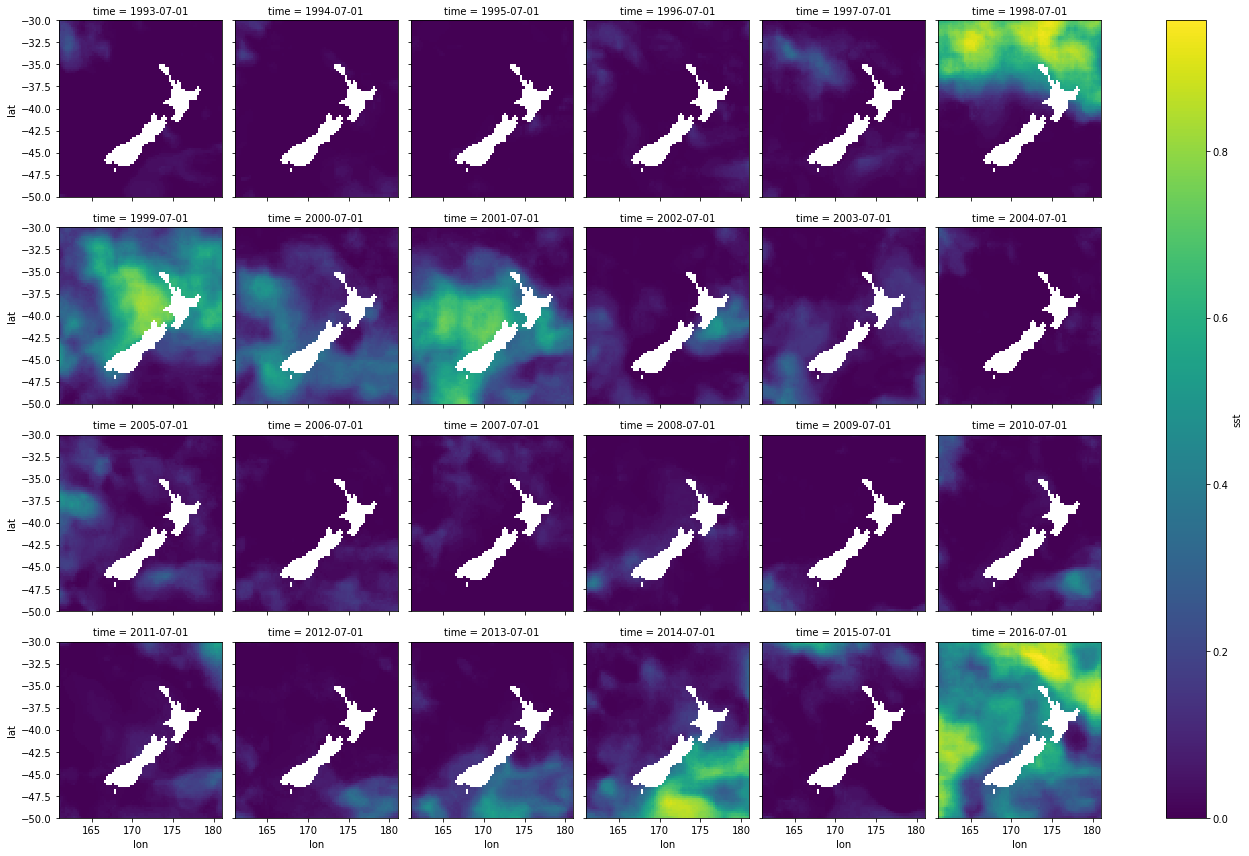

In [54]:
dgcms_probs.sel(time=(dgcms_probs.time.dt.month == 7), step=1)['sst'].plot(col='time', col_wrap=6)

### selects a threshold probability 

In [55]:
prob_thresh = 0.25

In [56]:
dgcms_probs_to_binary = (dgcms_probs[varname] >= prob_thresh)

In [57]:
dgcms_probs_to_binary = dgcms_probs_to_binary.to_dataset(name='sst')

### select one leadtime, e.g. one month ahead, and align with observations 3

In [58]:
dgcms_probs_to_binary_step = dgcms_probs_to_binary.isel(step=1)

In [59]:
dgcms_probs_to_binary_step = dgcms_probs_to_binary_step.shift({'time':1})

In [60]:
dgcms_probs_to_binary_step = dgcms_probs_to_binary_step.dropna('time')

In [61]:
t, t = xr.align(obs_binary.time, dgcms_probs_to_binary_step.time)

### A = true positives 

In [62]:
A = ((dgcms_probs_to_binary_step.sel(time=t) == 1) * (obs_binary.sel(time=t) == 1))

In [63]:
A = A.sum('time') * mask_obs

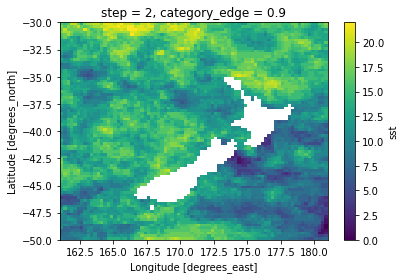

In [64]:
A[varname].plot()

### B = False positives 

In [65]:
B = ((dgcms_probs_to_binary_step.sel(time=t) == 1) * (obs_binary.sel(time=t) == 0))

In [66]:
B = B.sum('time') * mask_obs

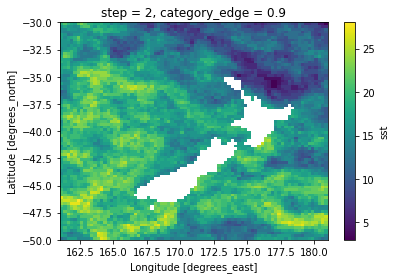

In [67]:
B[varname].plot()

### C = False negatives 

In [68]:
C = ((dgcms_probs_to_binary_step.sel(time=t) == 0) * (obs_binary.sel(time=t) == 1))

In [69]:
C = C.sum('time') * mask_obs

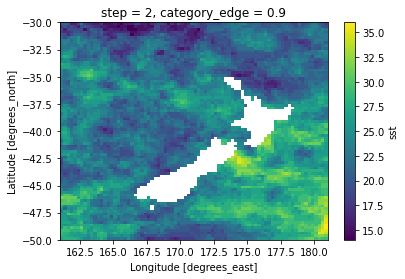

In [70]:
C[varname].plot()

### D = True negatives 

In [71]:
D = ((dgcms_probs_to_binary_step.sel(time=t) == 0) * (obs_binary.sel(time=t) == 0))

In [72]:
D = D.sum('time') * mask_obs

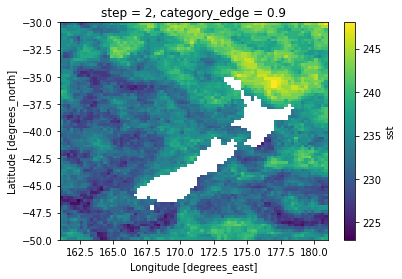

In [73]:
D[varname].plot()

### trying to implement the SEDI 

see reference: Ferro, C. A. T., and D. B. Stephenson, 2011: Extremal Dependence Indices: Improved Verification Measures for Deterministic Forecasts of Rare Binary Events. Weather and Forecasting, 26, 699–713, https://doi.org/10.1175/WAF-D-10-05030.1.
 

See implementation in Python as part of the [https://github.com/WFRT/verif](https://github.com/WFRT/verif) package  

code (class Sedi(Contingency)):  https://github.com/WFRT/verif/blob/master/verif/metric.py 

In [74]:
def SEDI_from_ABCD(A, B, C, D): 
    """
    calculate the SEDI (Symmetric extremal dependency index) 
    
    Reference: 
    Ferro, C. A. T., and D. B. Stephenson, 2011: 
    Extremal Dependence Indices: Improved Verification Measures for Deterministic Forecasts of Rare Binary Events. 
    Weather and Forecasting, 26, 699–713, https://doi.org/10.1175/WAF-D-10-05030.1.
    
    The arguments are: 
    
    A = True positives 
    B = False Positives 
    C = False Negatives
    D = True Negatives
    
    see contingency table (Table 1) in Ferro et al., 2011
    
    and their Equation 2
    
    """
    
    
    N = A + B + C + D
    
    # False Alarm rate (F)
    F = B / 1.0 / (B + D)
    
    # Hit Rate (H)
    H = A / 1.0 / (A + C)
    
    # See equation 2) in Ferro et al.

    denom = np.log(F) + np.log(H) + np.log(1 - F) + np.log(1 - H)
    
    num = np.log(F) - np.log(H) - np.log(1 - F) + np.log(1 - H)
    
    SEDI = num / denom
    
    return SEDI

In [75]:
SEDI = SEDI_from_ABCD(A, B, C, D)

In [76]:
cbar_kwargs = {'shrink':0.7, 'label':'SEDI'}

In [77]:
prob_thresh * 100

25.0

In [78]:
cmap = plt.cm.RdBu_r

In [79]:
cmap.set_bad('0.8')

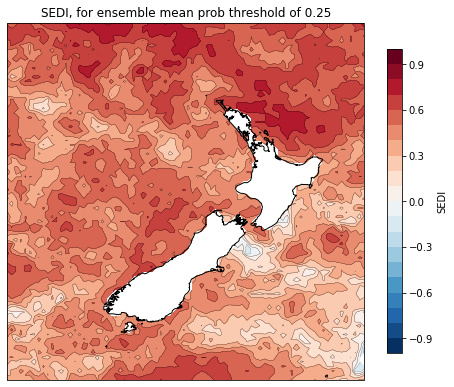

In [80]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(8,8))

SEDI[varname].plot.contourf(ax=ax, levels=np.arange(-1,1.01, 0.1), cmap=cmap, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

SEDI[varname].plot.contour(ax=ax, levels=np.arange(-1,1.01, 0.1), colors='k', transform=ccrs.PlateCarree(), linewidths=0.25)

ax.coastlines(resolution='10m')

ax.set_title(f'SEDI, for ensemble mean prob threshold of {prob_thresh}')

f.savefig(fig_path.joinpath(f'SEDI_ensemble_mean_probs_thresh_{int(prob_thresh * 100):03d}.png'), **fig_kwargs)

In [81]:
accuracy_score = (dgcms_probs_to_binary_step.sel(time=t) == obs_binary.sel(time=t))

In [82]:
accuracy_score = accuracy_score * mask_obs

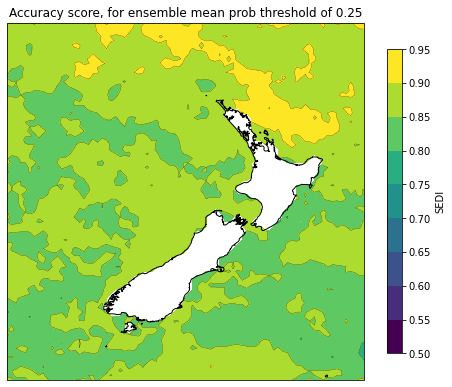

In [83]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(8,8))

accuracy_score.mean('time')[varname].plot.contourf(ax=ax, levels=np.arange(0.5, 1, 0.05), cmap='viridis', transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

accuracy_score.mean('time')[varname].plot.contour(ax=ax, levels=np.arange(0.5, 1, 0.05), colors='k', transform=ccrs.PlateCarree(), linewidths=0.25)

ax.coastlines(resolution='10m')

ax.set_title(f'Accuracy score, for ensemble mean prob threshold of {prob_thresh}')

f.savefig(fig_path.joinpath(f'acc_score_ensemble_mean_probs_thresh_{int(prob_thresh * 100):03d}.png'), **fig_kwargs)

Text(0.5, 1.0, 'Observed SST anomalies for 2016-08')

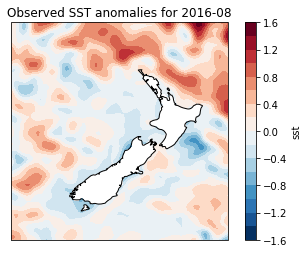

In [84]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
dset_obs_anoms.sel(time="2016-08").squeeze()["sst"].plot.contourf(transform=ccrs.PlateCarree(), levels=20)
ax.coastlines()
ax.set_title('Observed SST anomalies for 2016-08')

Text(0.5, 1.0, 'Observed MHW conditions (0 or 1) for 2016-08')

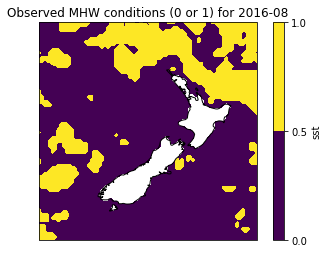

In [85]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
obs_binary.sel(time="2016-08").squeeze()["sst"].plot.contourf(transform=ccrs.PlateCarree(), levels=3)
ax.coastlines()
ax.set_title('Observed MHW conditions (0 or 1) for 2016-08')

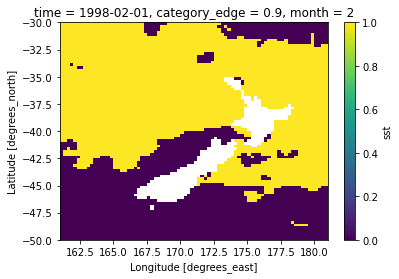

In [86]:

obs_binary.sel(time="1998-02").squeeze()["sst"].plot()

### Now try and calculate the SEDI etc, but over all the ensemble members, i.e. without calculating the ensemble mean [probability] first and selecting a threshold 

In [87]:
len(dgcms['member'])

206

In [88]:
all_members = dgcms.sel(step=1)

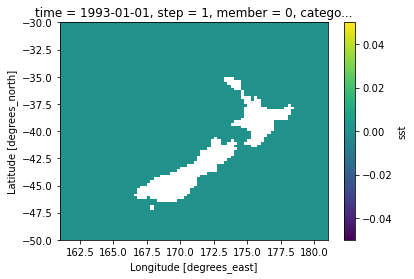

In [89]:
all_members.isel(time=0, member=0)[varname].plot()

### we shift the time by one month, to correspond to the observations for validation

In [90]:
all_members = all_members.shift({'time':1})

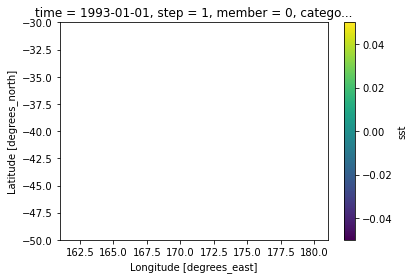

In [91]:
all_members.isel(time=0, member=0)[varname].plot()

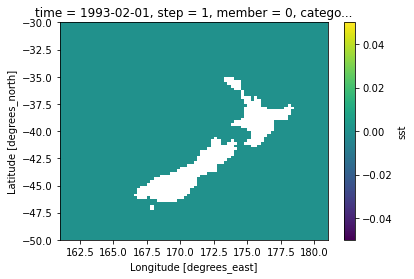

In [92]:
all_members.isel(time=1, member=0)[varname].plot()

### we select the slice from time 1 onwards

In [93]:
all_members = all_members.isel(time=slice(1, None))

In [94]:
t, t = xr.align(obs_binary.time, all_members.time)

In [95]:
len(t)

287

#### we collapse (stack) the time and members dimensions 

In [96]:
all_members = all_members.stack(tm=('time','member'))

In [97]:
tm = all_members['tm']

In [98]:
tm = tm.to_index()

In [99]:
tm = tm.get_level_values(0)

In [100]:
obs_by_members = obs_binary.sel(time=t)

In [101]:
obs_by_members = obs_by_members.sel(time=tm)

In [102]:
obs_by_members

<xarray.Dataset>
Dimensions:        (time: 59122, lat: 80, lon: 80)
Coordinates:
  * time           (time) datetime64[ns] 1993-02-01 1993-02-01 ... 2016-12-01
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
    category_edge  float64 0.9
    month          (time) int64 2 2 2 2 2 2 2 2 2 ... 12 12 12 12 12 12 12 12 12
    step           int64 1
Data variables:
    sst            (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [103]:
all_members = all_members.reset_index('tm')

In [104]:
all_members['tm'] = (('tm'), tm)

In [105]:
all_members['tm'].data[:10]

array(['1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [106]:
obs_by_members['time'].data[:10]

array(['1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [107]:
all_members = all_members.drop('time')

In [108]:
all_members = all_members.rename({'tm':'time'})

In [109]:
all_members.dims

Frozen({'lon': 80, 'lat': 80, 'time': 59122})

In [110]:
obs_by_members.dims

Frozen({'time': 59122, 'lat': 80, 'lon': 80})

### A = true positives 

In [111]:
A = ((all_members == 1) * (obs_by_members == 1))

In [112]:
A = A.sum('time') * mask_obs

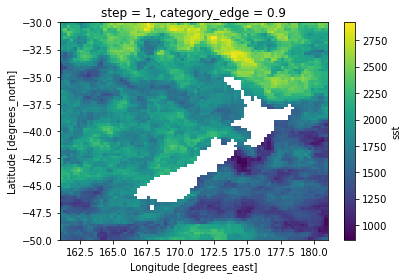

In [113]:
A[varname].plot()

### A = true positives 

In [114]:
A = ((all_members == 1) * (obs_by_members == 1))

In [115]:
A = A.sum('time') * mask_obs

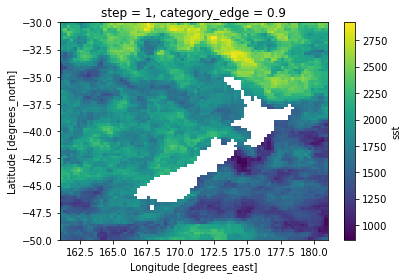

In [116]:
A[varname].plot()

### B = false positives 

In [117]:
B = ((all_members == 1) * (obs_by_members == 0))

In [118]:
B = B.sum('time') * mask_obs

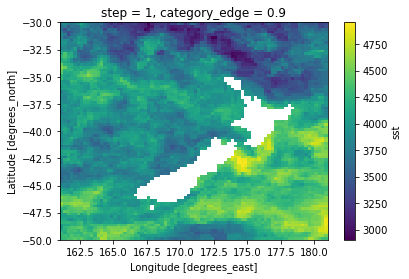

In [119]:
B[varname].plot()

### C = false negatives

In [120]:
C = ((all_members == 0) * (obs_by_members == 1))

In [121]:
C = C.sum('time') * mask_obs

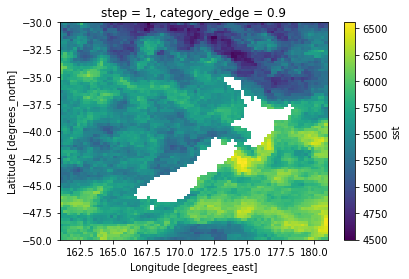

In [122]:
C[varname].plot()

### D = true negatives

In [123]:
D = ((all_members == 0) * (obs_by_members == 0))

In [124]:
D = D.sum('time') * mask_obs

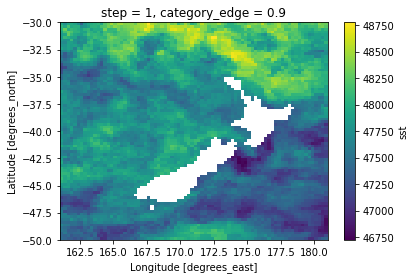

In [125]:
D[varname].plot()

In [126]:
SEDI_all_members = SEDI_from_ABCD(A, B, C, D)

In [127]:
cbar_kwargs = {'shrink':0.7, 'label':'SEDI'}

In [128]:
cmap = plt.cm.RdBu_r

In [129]:
cmap.set_bad('0.8')

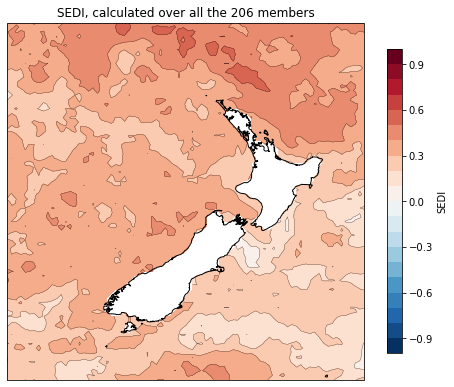

In [130]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(8,8))

SEDI_all_members[varname].plot.contourf(ax=ax, levels=np.arange(-1,1.01, 0.1), cmap=cmap, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

SEDI_all_members[varname].plot.contour(ax=ax, levels=np.arange(-1,1.01, 0.1), colors='k', transform=ccrs.PlateCarree(), linewidths=0.25)

ax.coastlines(resolution='10m')

ax.set_title(f"SEDI, calculated over all the {len(dgcms['member'])} members")

f.savefig(fig_path.joinpath(f'SEDI_all_members_ensemble.png'), **fig_kwargs)
f.savefig(fig_path.joinpath(f'SEDI_all_members_ensemble.pdf'), **fig_kwargs)